# The Deutsch-Josza algorithm
- The DJ algorithm allows us to determine if the function is constant or balanced with just one check, provided we express the function as an **oracle**.
- We know that we want our quantum states to be modified by the application of the function, so that we can figure out if the function is **constant or balanced**. Therefore, we will have to express the **function in the form of an operator**, or a gate. 
- Also, just like all other quantum operators, the gate we make for the function will have to be reversible. An **oracle** is exactly this reversible gate form of the function we want to check.

In [52]:
from random import getrandbits
from qiskit import *
import numpy as np

# STEPS

Here are the steps of the DJ algorithm for a n-bit function:

- Initiate a quantum circuit of n+1 qubits
- Apply an X gate to the last qubit ( for a phase kickback )
- Apply Hadamard transform to all the qubits
- Apply the oracle to the qubits
- Apply H gates to all the qubits 
- Measure 𝑞0. If the result is 0, the oracle is constant. If it is 1, the oracle is balanced.

Notice that we only invoked the oracle (i.e. applied the function) once in this algorithm.

## Defining randomized function

In [60]:
def get_function(n):
    '''Get the function for the 2^n inputs'''
    inputs = 2**(n) 
    bit = getrandbits(1)
    func = []
    
    # is bit is 0 -> constant 
    if bit == 0:
        print("Constant function selected!")
        one = getrandbits(1)
        if one is True:
            func = [1 for _ in range(inputs)]
        else:
            func = [0 for _ in range(inputs)]
        func.insert(0,'constant')
    # is bit is 1 -> balanced
    else:
        print("Balanced function selected!")
        func.append('balanced')
        per = np.random.permutation(inputs)
        for k in per:
            # at even you get 0, at odd you get 1 
            # since even number of elements, always equal
            # zeroes and ones :)
            func.append(k%2)
    
    return func

# Defining oracle for n bits 
- Basically just apply an MCX gate whenever f(x) is 1 for an input combination and nothing when it is zero

In [73]:
def get_oracle(function):
    qubits = int(np.log2(len(function)-1))
    qc = QuantumCircuit(qubits+1, name='Oracle')
    # now see what type of function is it
    if(function[0] == 'balanced'):
        function = function[1:]
        # wherever it is 0, don't do anyhing
        for i, k in enumerate(function):
            if k == 1:
                # first get the binary representation of i
                b = bin(i)[2:]
                b = b.zfill(qubits)[:qubits]
                # apply xs
                qc.barrier()
                for j, h in enumerate(b):
                    if(h == '1'):    
                        qc.x(qubits - j -1)
                # apply mcx
                qc.mcx([i for i in range(qubits)], qubits)
                # reverse the operation
                for j, h in enumerate(b):
                    if(h == '1'):
                        qc.x(qubits - j - 1)
                qc.barrier()
            else:
                pass
    else:
        function = function[1:]
        if(sum(function) == 0):
            pass
        else:
            qc.x(qubits)
    return qc

Balanced function selected!
Function selected : ['balanced', 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1]


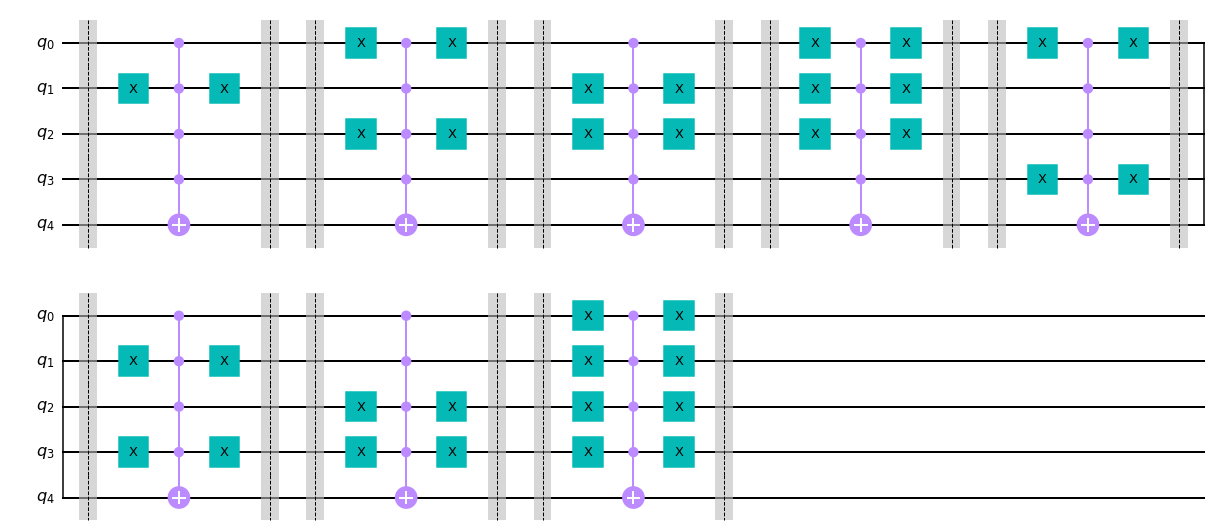

In [86]:
func = get_function(4)
oracle = get_oracle(func)
print("Function selected :",func)
display(oracle.draw('mpl'))

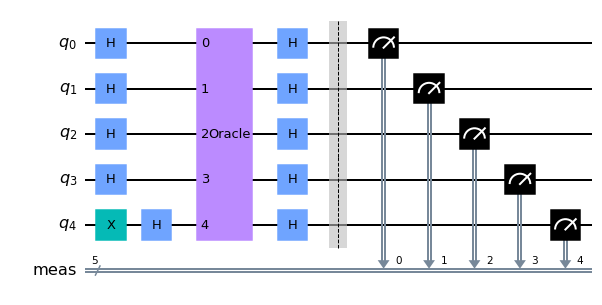

In [87]:
q = QuantumCircuit(5)
q.x(4)
q.h([0,1,2,3,4])
q.append(oracle,q.qubits,q.clbits)
q.h([0,1,2,3,4])
q.measure_all()
q.draw('mpl')

{'11100': 1}


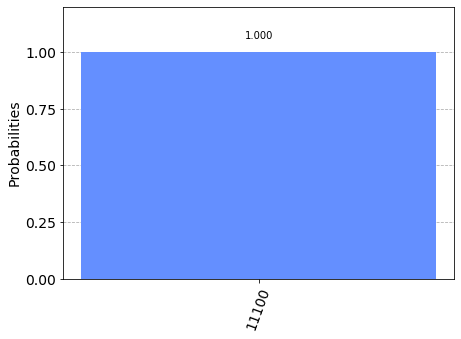

In [88]:
backend = Aer.get_backend('qasm_simulator')
counts = execute(q,backend = backend,shots=1).result().get_counts()
print(counts)
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

- This histogram protrays the fact that the **qubit 0** is measured as 1 with a very high probability and thus it shows that the **ORACLE WORKS WITH A SINGLE SHOT AND THUS PROVIDES THE REQUIRED SPEED UP THAT THE ALGORITHM PROVIDES**

## TESTING FOR 100 TESTS

In [99]:
correct , incorrect = 0,0 
for _ in range(100):
    func = get_function(4)
    oracle = get_oracle(func)
    if(func[0] == 'balanced'):
        print("Qubit 0 should be 1")
    else:
        print("Qubit 0 should be 0")
        
    # make the circuit
    q = QuantumCircuit(5)
    q.x(4)
    q.h([0,1,2,3,4])
    q.append(oracle,q.qubits,q.clbits)
    q.h([0,1,2,3,4])
    q.measure_all()
#     q.draw('mpl')

    backend = Aer.get_backend('qasm_simulator')
    counts = execute(q,backend = backend,shots=1).result().get_counts()
    print(counts)
    
    BIT0 = list(counts.keys())[0]
    if BIT0[-1] == '1' and func[0]=='balanced':
        correct+=1
    elif BIT0[-1] == '0' and func[0]=='constant':
        correct+=1
    else:
        incorrect+=1 

print("Number of correct identifications :",correct)
print("Number of incorrect identifications :",incorrect)

Balanced function selected!
Qubit 0 should be 1
{'11010': 1}
Balanced function selected!
Qubit 0 should be 1
{'11001': 1}
Constant function selected!
Qubit 0 should be 0
{'10000': 1}
Balanced function selected!
Qubit 0 should be 1
{'11010': 1}
Balanced function selected!
Qubit 0 should be 1
{'10111': 1}
Balanced function selected!
Qubit 0 should be 1
{'10010': 1}
Balanced function selected!
Qubit 0 should be 1
{'11011': 1}
Constant function selected!
Qubit 0 should be 0
{'10000': 1}
Balanced function selected!
Qubit 0 should be 1
{'10100': 1}
Constant function selected!
Qubit 0 should be 0
{'10000': 1}
Constant function selected!
Qubit 0 should be 0
{'10000': 1}
Constant function selected!
Qubit 0 should be 0
{'10000': 1}
Constant function selected!
Qubit 0 should be 0
{'10000': 1}
Constant function selected!
Qubit 0 should be 0
{'10000': 1}
Balanced function selected!
Qubit 0 should be 1
{'11110': 1}
Constant function selected!
Qubit 0 should be 0
{'10000': 1}
Balanced function select

- Since the qasm simulator introduces some kind of error, the correct outputs are generated in ~ 80 % of the cases as shown